In [1]:
import os
import glob
from collections import Counter
import calendar
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import genextreme as gev
import xclim as xc
import numpy as np
import cartopy.crs as ccrs
import cmocean
import seaborn as sns

from unseen import fileio
from unseen import indices

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Parameters
dpi = 300

In [3]:
# Parameters
rn90day_file = "/g/data/xv83/dbi599/hydrotas/data/Rn90day_AGCD-CSIRO_r005_1900-2022_annual-jul-to-jun_hydrotas.zarr.zip"
pr_file = "/g/data/xv83/dbi599/hydrotas/data/pr_AGCD-CSIRO_r005_1900-2022_day_hydro-tas.zarr.zip"
region_name = "hydro-tas"
nino_file = "/g/data/xv83/dbi599/hydrotas/data/nino34-anomaly_HadISST_1870-2022_base-1981-2010.nc"

In [4]:
assert os.path.isfile(rn90day_file), "Must provide an rn90day file (papermill option -p rn90day_file [filepath])"
assert os.path.isfile(nino_file), "Must provide a Nino 3.4 file (papermill option -p nino_file [filepath])"
assert 'region_name' in locals(), "Must provide a region name (papermill option -p region_name [name])"

#### Analyse and plot Rx14day data

In [5]:
ds_rn90day = fileio.open_dataset(rn90day_file)
ds_rn90day = ds_rn90day.dropna('time')

/g/data/xv83/dbi599/hydrotas/figures/Rn90day_timeseries_AGCD_hydro-tas.png


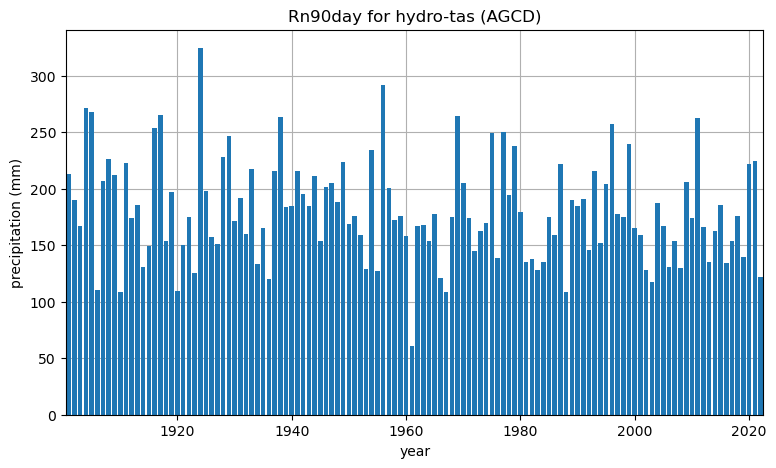

In [6]:
fig, ax = plt.subplots(figsize=[9, 5])
values = ds_rn90day['pr'].values
years = ds_rn90day.time.dt.year.values
plt.bar(years, values, zorder=2)
plt.xlim(years[0] - 0.5, years[-1] + 0.5)
plt.title(f'Rn90day for {region_name} (AGCD)')
plt.ylabel('precipitation (mm)')
plt.xlabel('year')
plt.grid(zorder=3)
outfile = f'/g/data/xv83/dbi599/hydrotas/figures/Rn90day_timeseries_AGCD_{region_name}.png'
print(outfile)
plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

In [7]:
years = ds_rn90day['time'].dt.year.values
df_rn90day = pd.DataFrame(index=years)
df_rn90day['pr'] = ds_rn90day['pr'].values
df_rn90day['event_time'] = ds_rn90day['event_time'].values

In [8]:
event_months = [int(date[5:7]) for date in ds_rn90day['event_time'].values]
event_years = [int(date[0:4]) for date in ds_rn90day['event_time'].values]

In [9]:
df_rn90day['month'] = event_months

In [10]:
monthly_ave = df_rn90day.groupby('month').mean(['pr'])

In [11]:
ranked_events = df_rn90day.sort_values(['pr'], ascending=True)
ranked_events.head(n=10)

,pr,event_time,month
1961,61.120384,1961-02-22,2
1967,108.529274,1967-04-23,4
1910,108.546280,1910-04-23,4
1988,108.699432,1988-04-12,4
1920,109.297791,1920-02-23,2
1906,110.435707,1906-02-16,2
2003,117.805290,2003-03-07,3
1936,120.544983,1936-03-25,3
1966,120.871017,1966-03-08,3
2022,121.778320,2022-04-09,4


NameError: name 'ds_pr' is not defined

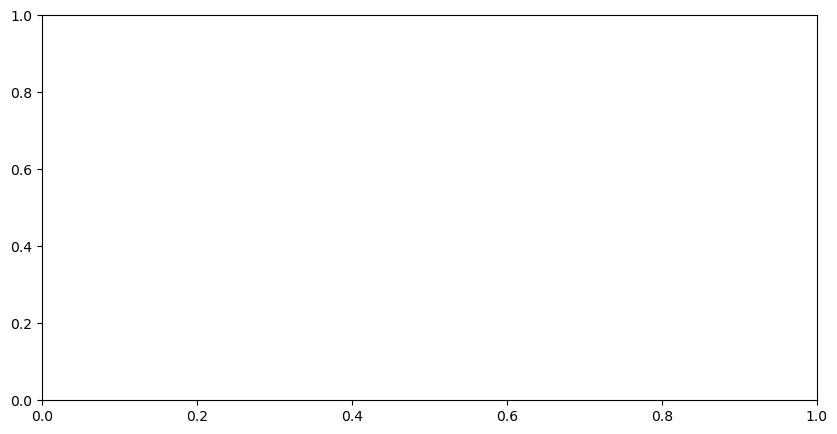

In [12]:
for rank in range(5):
    fig, ax = plt.subplots(figsize=[10, 5])
    end_date = ranked_events.iloc[[rank]]['event_time'].values[0]

    day = int(end_date[8:10])
    month = int(end_date[5:7])
    ndays = calendar.mdays[month]
    month_name = calendar.month_name[month]
    year = end_date[0:4]
    colors = ['tab:blue'] * ndays
    for i in range(14):
        colors[day - 1 - i] = 'tab:orange'
    month_start = end_date[0:8] + '01'
    month_end = end_date[0:8] + str(ndays)
    ds_month = ds_pr['pr'].sel({'time': slice(month_start, month_end)})
    dates = ds_month.time.dt.strftime('%Y-%m-%d').values
    values = ds_month.values
    days = np.arange(ndays + 1)[1:]
    plt.bar(days, values, color=colors)
    plt.xticks(days)
        
    plt.ylim(0, 100)
    plt.xlim(0.5, ndays + 0.5)
    plt.xlabel('day of month')
    plt.ylabel('precipitation (mm)')
    plt.title(f'Daily rainfall over {region_name}, {month_name} {year}')
    plt.show()

In [13]:
rn90day_max = df_rn90day['pr'].values.min()
print(rn90day_max)

61.120384


/g/data/xv83/dbi599/hydrotas/figures/Rn90day_timing_AGCD_hydro-tas.png


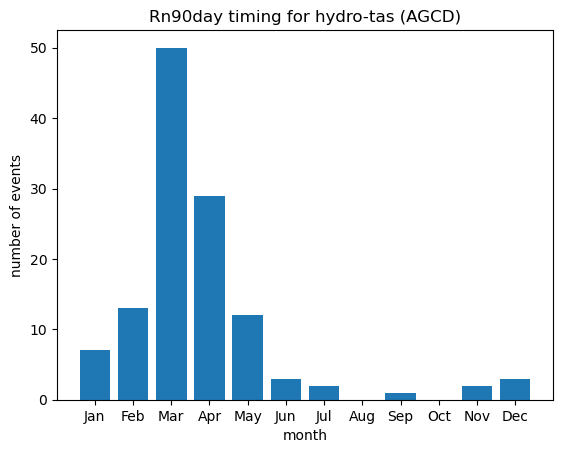

In [14]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rn90day timing for {region_name} (AGCD)')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
outfile = f'/g/data/xv83/dbi599/hydrotas/figures/Rn90day_timing_AGCD_{region_name}.png'
print(outfile)
plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (12,) and arg 1 with shape (10,).

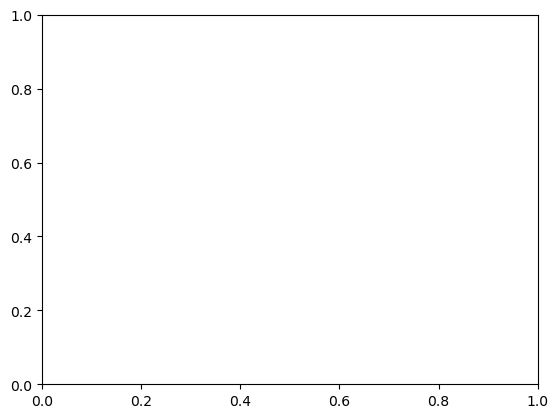

In [15]:
months = np.arange(1, 13)
averages = monthly_ave['pr'].values

plt.bar(months, averages)
plt.title(f'Rn90day average magnitude for {region_name} (AGCD)')
plt.ylabel('precipitation (mm)')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
outfile = f'/g/data/xv83/dbi599/hydrotas/figures/Rn90day_magnitude_AGCD_{region_name}.png'
print(outfile)
plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

In [18]:
nino34_ds = xr.open_dataset(nino_file)

In [19]:
event_nino34 = []
for month, year in zip(event_months, event_years):
    value = nino34_ds['sst'][(nino34_ds['time'].dt.month == month) & (nino34_ds['time'].dt.year == year)].values[0]
    event_nino34.append(value)
event_nino34 = np.array(event_nino34)

/g/data/xv83/dbi599/hydrotas/figures/Rx14day_ENSO_AGCD_hydro-tas.png


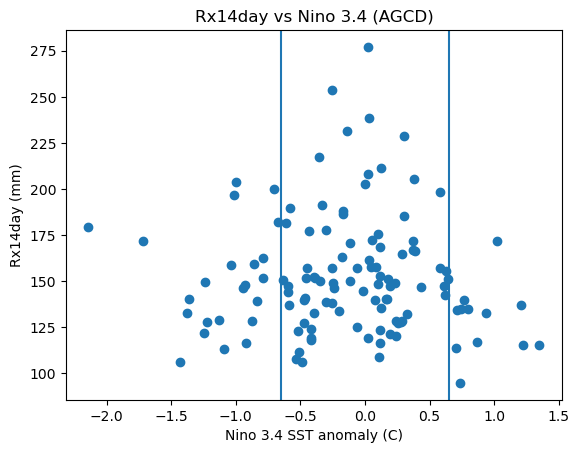

In [20]:
plt.scatter(event_nino34, ds_rn90day['pr'].values)
plt.title(f'Rn90day vs Nino 3.4 (AGCD)')
plt.ylabel('Rn90day (mm)')
plt.xlabel('Nino 3.4 SST anomaly (C)')
plt.axvline(0.65)
plt.axvline(-0.65)
outfile = f'/g/data/xv83/dbi599/hydrotas/figures/Rn90day_ENSO_AGCD_{region_name}.png'
print(outfile)
plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

In [21]:
gev_shape, gev_loc, gev_scale = indices.fit_gev(df_rn90day['pr'].values)
print(f'Shape parameter: {gev_shape:.2f}')
print(f'Location parameter: {gev_loc:.2f}')
print(f'Scale parameter: {gev_scale:.2f}')

Shape parameter: -0.03
Location parameter: 138.10
Scale parameter: 24.29


/g/data/xv83/dbi599/hydrotas/figures/Rx14day_histogram_AGCD_hydro-tas.png


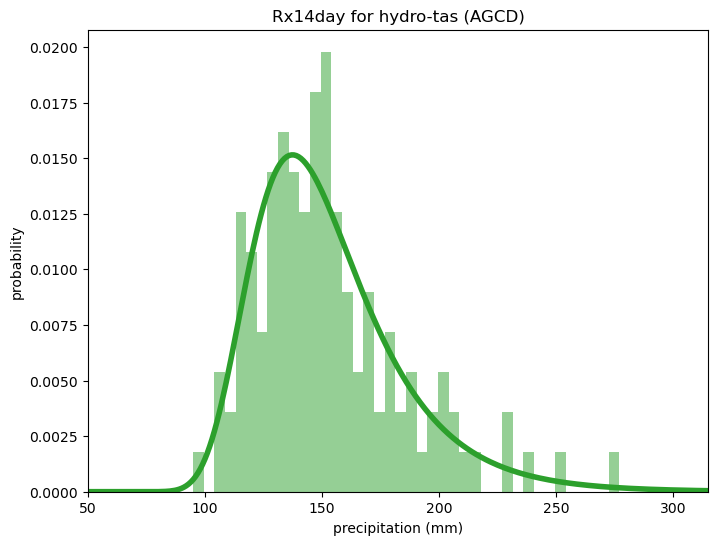

In [22]:
fig, ax = plt.subplots(figsize=[8, 6])
gev_xvals = np.arange(0, 700)
df_rn90day['pr'].plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
gev_pdf = gev.pdf(gev_xvals, gev_shape, gev_loc, gev_scale)
plt.plot(gev_xvals, gev_pdf, color='tab:green', linewidth=4.0)
plt.xlabel('precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Rn90day for {region_name} (AGCD)')
plt.xlim(50, 315)
outfile = f'/g/data/xv83/dbi599/hydrotas/figures/Rn90day_histogram_AGCD_{region_name}.png'
print(outfile)
plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

In [23]:
for event_rank in range(5):
    event = float(ranked_events.iloc[[event_rank]]['pr'].values)
    date = ranked_events.iloc[[event_rank]]['event_time'].values[0]
    event_probability = gev.sf(event, gev_shape, loc=gev_loc, scale=gev_scale)
    event_return_period = 1. / event_probability
    event_percentile = (1 - event_probability) * 100
    print(f'{date}: {event:.1f}mm')
    print(f'{event_return_period:.0f} year return period')
    print(f'{event_percentile:.2f}% percentile\n')

1960-04-28: 277.1mm
200 year return period
99.50% percentile

1923-05-24: 254.0mm
88 year return period
98.86% percentile

1947-06-24: 238.6mm
50 year return period
98.01% percentile

1929-04-14: 231.4mm
39 year return period
97.42% percentile

1958-05-29: 228.8mm
35 year return period
97.15% percentile



#### Meteorology of the most extreme events

### 14-day aggregates

In [71]:
def plot_average(color_da, color_var, contour_da, contour_var, start_date, end_date):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var == 'pr':
        levels = [0, 10, 20, 40, 80, 160, 320, 740]
        label = 'total precipitation (mm)'
        cmap = cmocean.cm.rain
        extend = 'max'
    elif color_var == 'ua300':
        levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
        label = '300hPa zonal wind'
        cmap='RdBu_r'
        extend = 'both'
    else:
        raise ValueError('Invalid color variable')
    color_da.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend=extend,
        cbar_kwargs={'label': label},
    )
    
    if contour_var == 'z500':
        levels = np.arange(5000, 6300, 50)
    elif contour_var == 'psl':
        levels = np.arange(900, 1100, 2.5)
    elif contour_var == 'ua300':
        levels = np.arange(15, 60, 5)
    else:
        raise ValueError('Invalid contour variable')
    lines = contour_da.plot.contour(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        levels=levels,
        colors=['0.1']
    )
    ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
    #plt.savefig(
    #    f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
    #    bbox_inches='tight',
    #    facecolor='white',
    #    dpi=300
    #)
    plt.show()

In [4]:
z500_file = '/g/data/rt52/era5/pressure-levels/reanalysis/z/1960/z_era5_oper_pl_19600401-19600430.nc'
pr_file = '/g/data/rt52/era5/single-levels/reanalysis/mtpr/1960/mtpr_era5_oper_sfc_19600401-19600430.nc'
psl_file = '/g/data/rt52/era5/single-levels/reanalysis/msl/1960/msl_era5_oper_sfc_19600401-19600430.nc'
ua300_file = '/g/data/rt52/era5/pressure-levels/reanalysis/u/1960/u_era5_oper_pl_19600401-19600430.nc'

In [5]:
z_ds = xr.open_mfdataset(z500_file)
pr_ds = xr.open_mfdataset(pr_file)
psl_ds = xr.open_mfdataset(psl_file)
ua_ds = xr.open_mfdataset(ua300_file)

In [8]:
start_date = '1960-04-15'
end_date = '1960-04-28'

In [13]:
pr_daily = pr_ds.sel({'time': slice(start_date, end_date)}).resample(time='1D').mean(dim='time')
pr_daily['mtpr'] = pr_daily['mtpr'] * 86400
pr_daily['mtpr'].attrs['units'] = 'mm d-1'

In [19]:
psl_daily = psl_ds.sel({'time': slice(start_date, end_date)}).resample(time='1D').mean(dim='time')
psl_daily['msl'] = psl_daily['msl'] / 100
psl_daily['msl'].attrs['units'] = 'hPa'

In [34]:
z500_daily = z_ds.sel({'time': slice(start_date, end_date), 'level': 500}).resample(time='1D').mean(dim='time')
z500_daily['z'] = z500_daily['z'] / 9.8
z500_daily['z'].attrs['units'] = 'm'

In [26]:
u300_daily = ua_ds.sel({'time': slice(start_date, end_date), 'level': 300}).resample(time='1D').mean(dim='time')

In [35]:
z500_da_mean = z500_daily['z'].mean('time', keep_attrs=True)
pr_da_sum = pr_daily['mtpr'].sum('time', keep_attrs=True)
psl_da_mean = psl_daily['msl'].mean('time', keep_attrs=True)
ua300_da_mean = u300_daily['u'].mean('time', keep_attrs=True)    

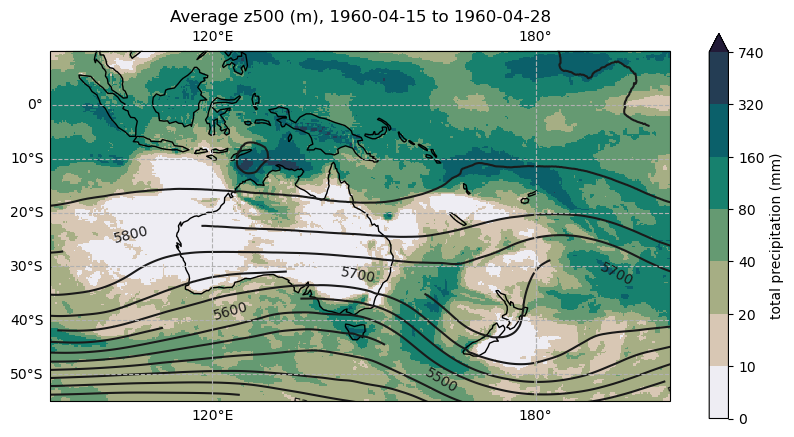

In [40]:
plot_average(pr_da_sum, 'pr', z500_da_mean, 'z500', start_date, end_date)

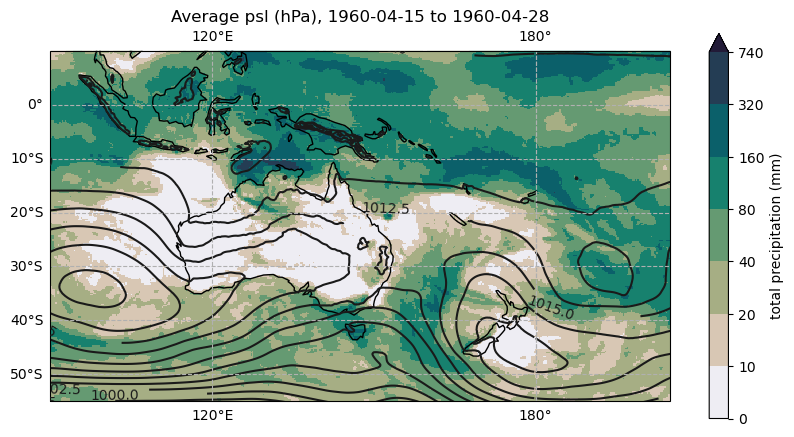

In [41]:
plot_average(pr_da_sum, 'pr', psl_da_mean, 'psl', start_date, end_date)

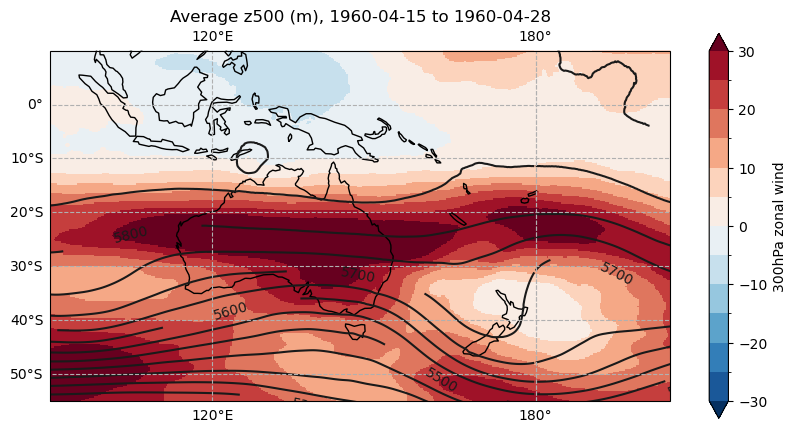

In [42]:
plot_average(ua300_da_mean, 'ua300', z500_da_mean, 'z500', start_date, end_date)

### Day-by-day

In [47]:
def plot_days(contour_var, start_date, end_date):
    """Plot days"""
    
    if contour_var == 'z500':
        contour_da = z500_daily['z']
    elif contour_var == 'psl':
        contour_da = psl_daily['msl']
    else:
        raise ValueError('Invalid contour variable')
    
    fig = plt.figure(figsize=[20, 18])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    
    if contour_var == 'z500':
        levels = np.arange(5000, 6300, 75)
    elif contour_var == 'psl':
        levels = np.arange(900, 1100, 5)

    plot_order = [1, 4, 7, 10, 13, 2, 5, 8, 11, 14, 3, 6, 9, 12, 15]
    for day in range(14):
        ax = fig.add_subplot(5, 3, plot_order[day], projection=map_proj)
        pr_daily['mtpr'].isel({'time': day}).plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmocean.cm.rain,
            levels=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            extend='max',
            cbar_kwargs={'label': 'total precipitation (mm)'},
        )
    
        lines = contour_da.isel({'time': day}).plot.contour(
            ax=ax,
            transform=ccrs.PlateCarree(),
            levels=levels,
            colors=['0.1']
        )
        ax.clabel(lines, colors=['0.1'], manual=False, inline=True)
        ax.coastlines()
        ax.gridlines(linestyle='--', draw_labels=True)
        date = str(pr_daily.isel({'time': day})['time'].dt.strftime('%d %b').values)
        ax.set_title(date)
        ax.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    plt.suptitle(f'Daily {contour_var} ({contour_da.units})')
#    plt.savefig(
#        f'{contour_var}_days_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

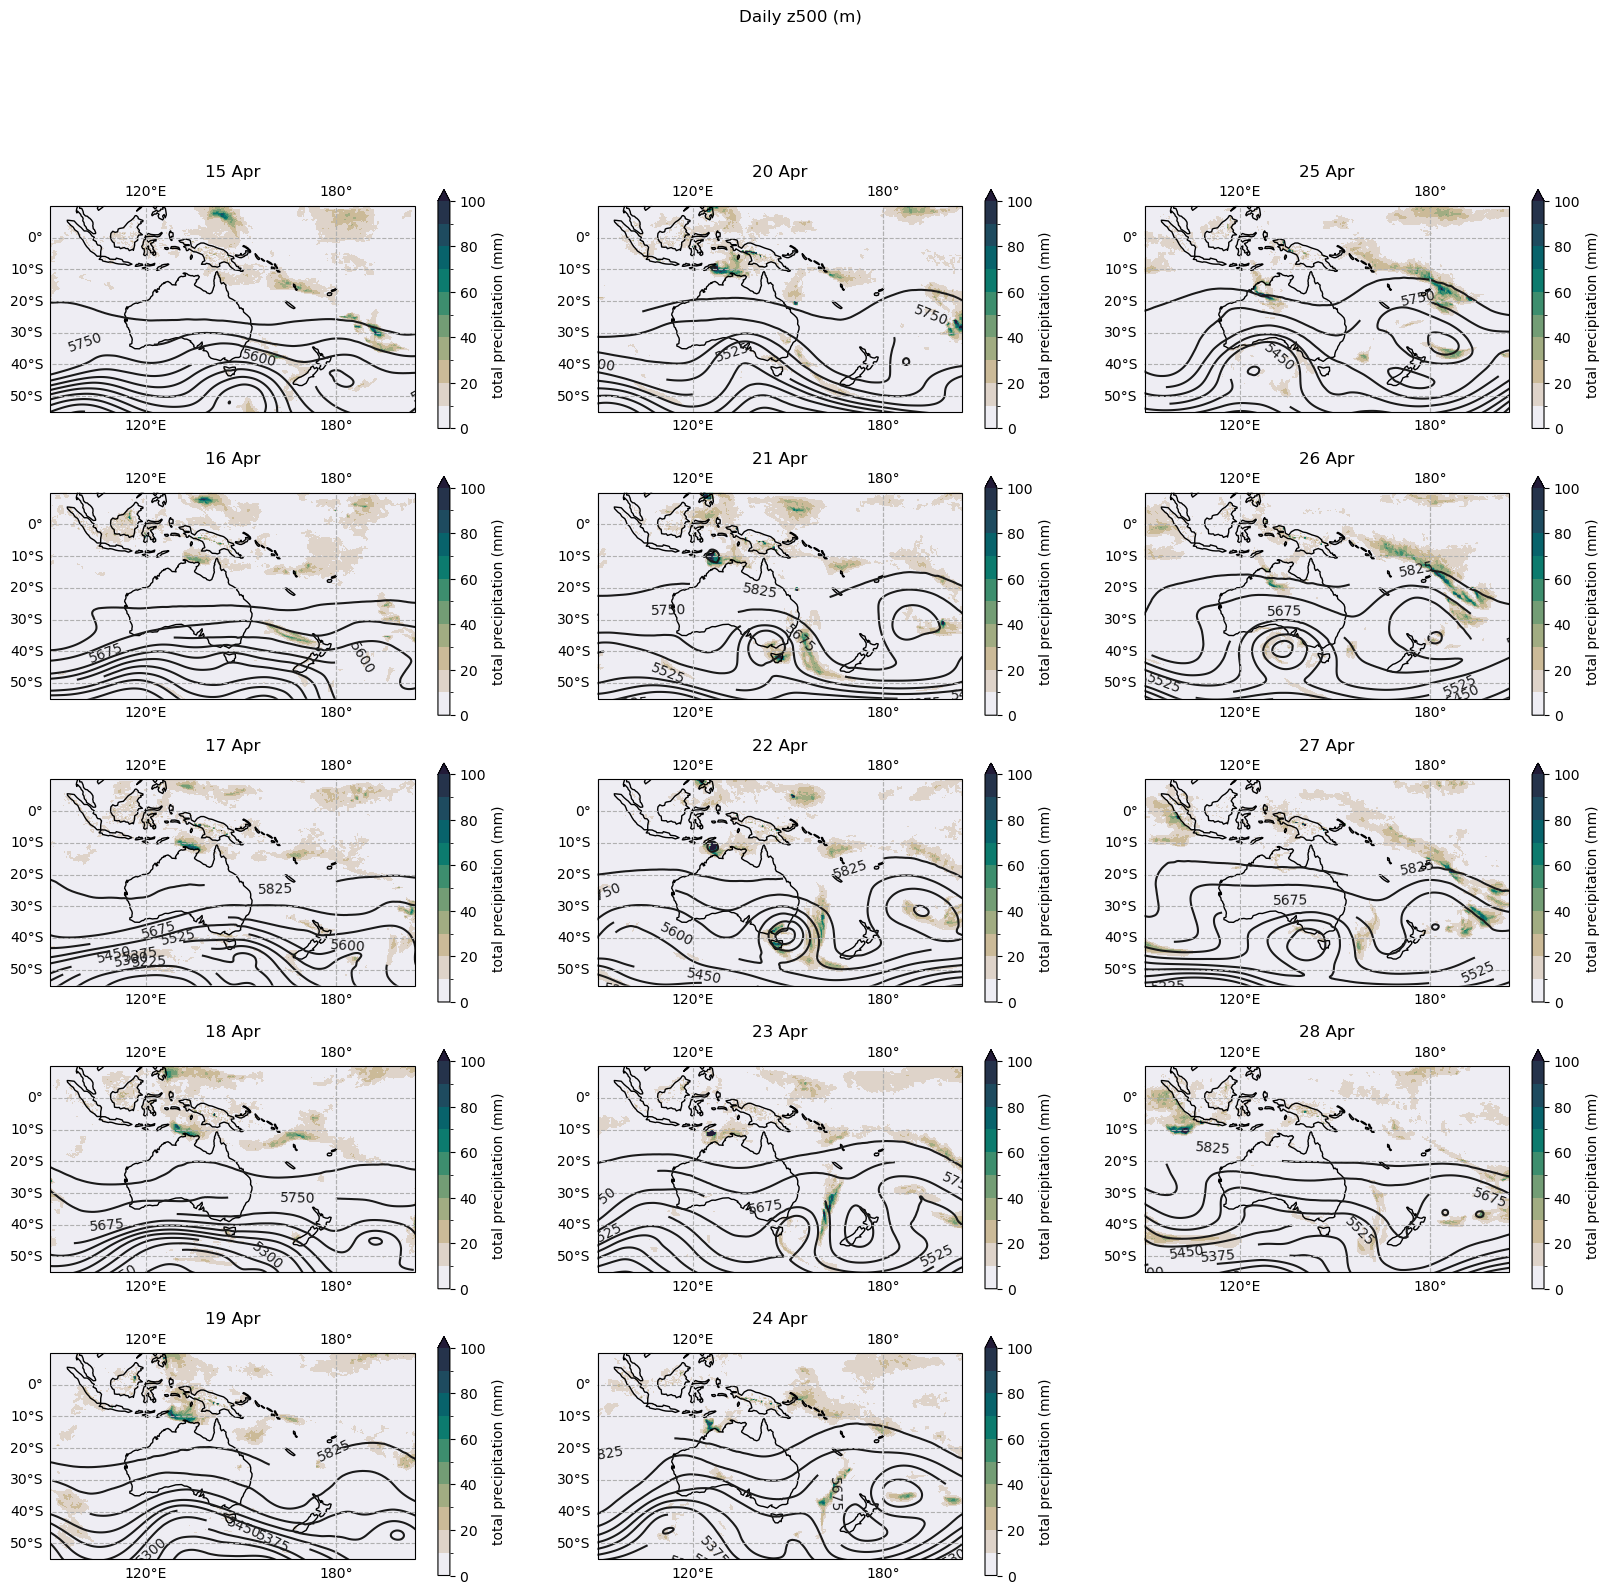

In [48]:
plot_days('z500', start_date, end_date)

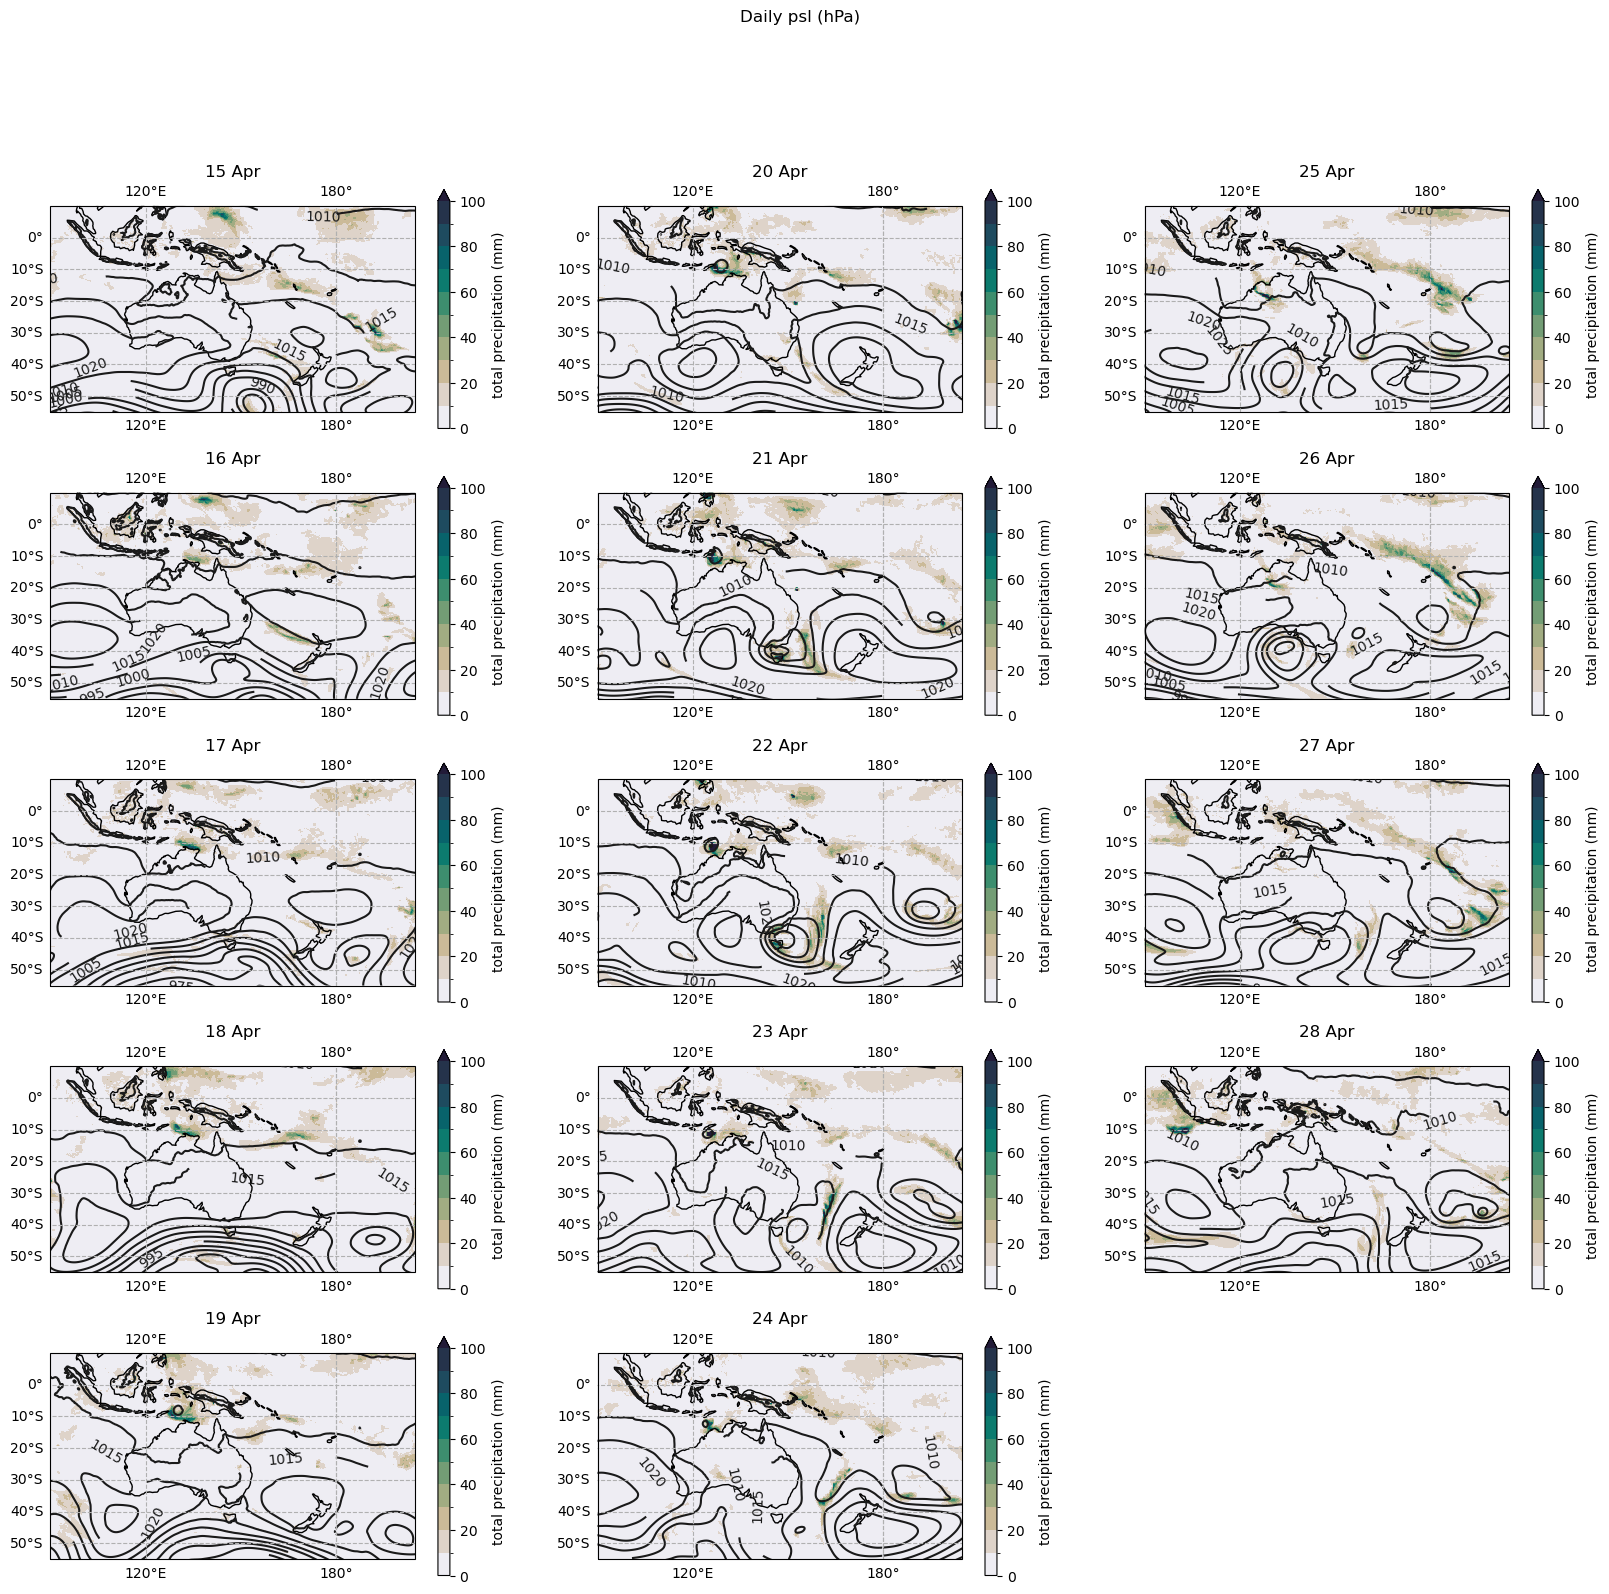

In [49]:
plot_days('psl', start_date, end_date)